In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
# import sys
# import datetime
from sklearn.model_selection import train_test_split
import tensorflow as tf
# import csv
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

In [2]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
df = pd.DataFrame(columns=['id', 'target'])
print(train.shape[0], test.shape[0])
test.head(5)

7613 3263


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [3]:
sentences = train['text']
labels = train['target']
sentences_test = test['text']
print(sentences.shape)

(7613,)


In [4]:
embedding_dim = 100
max_length = 32
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
test_portion=.1

In [5]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
vocab_size=len(word_index)

train_sentences, validation_sentences = train_test_split(sentences, test_size = 0.1, random_state=42)
train_labels, validation_labels = train_test_split(labels, test_size = 0.1, random_state=42)
training_size=len(train_sentences)

print(train_sentences.shape, train_labels.shape, validation_sentences.shape, validation_labels.shape)

(6851,) (6851,) (762,) (762,)


In [6]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

test_sequences = tokenizer.texts_to_sequences(sentences_test)
test_padded = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)

print(train_padded.shape, validation_padded.shape)

(6851, 32) (762, 32)


In [7]:
import urllib

embeddings_index = {}
with urllib.request.urlopen("https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt") as url:
    for line in url:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector


In [8]:
tester=np.zeros((train_labels.shape[0], 1))
a=0
for x in train_labels:
    tester[a][0]=x
    a=a+1
    
train_labels=np.array(tester)

tester=np.zeros((validation_labels.shape[0], 1))
b=0
for x in validation_labels:
    tester[b][0]=x
    b=b+1

validation_labels=np.array(tester)

In [9]:
print(vocab_size+1, embedding_dim, max_length)
checkpoint = ModelCheckpoint('model', monitor='val_loss', save_best_only=True)

22701 100 32


In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length),
#     tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv1D(256, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.5), kernel_initializer='random_normal')),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, kernel_initializer='random_normal')),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.5), kernel_initializer='random_normal'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 20
history = model.fit(train_padded, train_labels, epochs=num_epochs, validation_data=(validation_padded, validation_labels), verbose=2, callbacks=[checkpoint])

print("Training Complete")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 100)           2270100   
_________________________________________________________________
conv1d (Conv1D)              (None, 28, 256)           128256    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7, 256)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 7, 256)            394240    
_________________________________________________________________
dropout (Dropout)            (None, 7, 256)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               164352    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [11]:
from sklearn.metrics import confusion_matrix
pred = []
for x in model.predict(validation_padded):
    y=float(x)
    pred.append(round(y))

conf_matrix = confusion_matrix(validation_labels, pred, labels=[1,0])
conf_matrix

array([[248,  88],
       [129, 297]], dtype=int64)

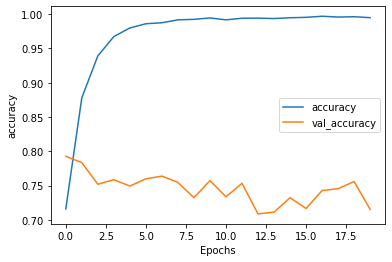

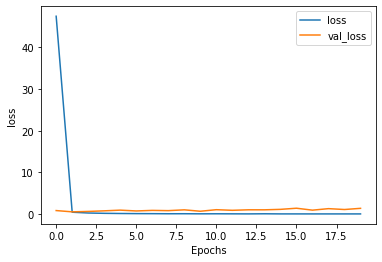

In [12]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [13]:
predictions=model.predict(test_padded)

In [14]:
df = pd.DataFrame(columns=['id', 'target'])
predictions.size

3263

In [15]:
for i in range(0, test_size):
    df = df.append({'id':int(test['id'][i]), 'target':round(float(predictions[i]))}, ignore_index=True)

df.to_csv('sample_submission.csv', encoding='utf-8', index=False)

NameError: name 'test_size' is not defined

In [ ]:
check=pd.read_csv('sample_submission.csv')
check

In [ ]:
import matplotlib.image  as mpimg

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!